# 2.4 Importing Array and Weather Data
Filename: unswDataImportArrayWeather.ipynb
## 2.4.1 Array
The culmination of our previous work comes here where we try to combine the Array data import and the Weather import for 2018. We have some issues to overcome especially now that we're beginning to handle a bit more data than my computer can easily throw around, but that's not to say it can't be done! To start we're going to repeat the same set of code from unswDataImportArray with some slight changes. One key objective during imports is to make sure we're reducing how much data we are holding at any one point; the way this is achieved is by leveraging pandas' header parameters when reading to avoid importing excess data.

In [1]:
import pandas as pd
import glob
import os
import numpy as np

headers = "TimeStamp;ExlSolIrr;IntSolIrr;SMA-h-On;TmpAmb C;TmpMdul C;WindVel km/h;A.Ms.Amp;A.Ms.Vol;A.Ms.Watt;A1.Ms.Amp"
headers = dict(enumerate(headers.split(';')))
headers = {k: headers[k] for k in (0, 4, 6, 9)} # choosing which headers we want
    
path = r"C:\Users\chayd\Documents\Projects\UNSW-Thesis\Data\2018-PV"
all_files = glob.iglob(os.path.join(path, "*csv"))
df1 = pd.concat((pd.read_csv(f, delimiter=";", header=None, skiprows=6, usecols=headers).assign(filename = os.path.basename(f)) for f in all_files))
df1 = df1.rename(columns = headers)
df1['TimeStamp'] = df1['filename'].str.split('.', expand = True)[0] + " " + df1['TimeStamp'] #setting timestamp to proper timestamp
df1.index = pd.to_datetime(df1['TimeStamp']) #setting index to a datetime64[ns] type
df1 = df1.drop(columns = ['filename', 'TimeStamp']) #dropping filename and TimeStamp as we don't need them anymore
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 55534 entries, 2018-01-01 00:00:00 to 2018-07-19 23:30:00
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TmpAmb C      55534 non-null  float64
 1   WindVel km/h  55534 non-null  float64
 2   A.Ms.Watt     27744 non-null  float64
dtypes: float64(3)
memory usage: 1.7 MB


In [2]:
df1.head()

,TmpAmb C,WindVel km/h,A.Ms.Watt
TimeStamp,,,
2018-01-01 00:00:00,22.33,11.86,NaN
2018-01-01 00:05:00,22.33,4.38,NaN
2018-01-01 00:10:00,22.31,5.08,NaN
2018-01-01 00:15:00,22.33,6.46,NaN
2018-01-01 00:20:00,22.27,4.34,NaN


## 2.4.2 Weather
So now that we have our Array data imported, we have to merge the weather data to the Array table without breaking anything. Using the original method in unswDataImportWeather causes issues with large dataframe sizes, so in the process of doing this I did break everything, many times. There are some critical changes to the code, being first that instead of creating a new weather table for everything, we are simply attempting to put weather data straight into the TEBT-Array dataframe (df1) in order to save memory. 

The key lines to doing this is the "firstMerge" on df1.merge(df2,..), and all subsequent df1.update(df2) calls. The functions merge, combine_first, and update all do slight variations on the same idea and so correct utilization was quite difficult; using a once off merge with all subsequent updates keeps the dataframe light. When attempting to use only df1.merge I resulted with a 1.4+ GB dataframe and about 10 minutes of computation time, only to realise instead of having 7 comlumns as a result that I had over 2000. Merge forces new columns to be made from the right_merge into the left_merge, so every merge was adding 3-4 columns. df1.update overcomes this by replacing the NaN's in already existing columns from columns of the same name in df2, overcoming the issue.

We also see that this time, many files (in this case, 20) didn't make the cut for the dataframe. These failed in the import, but half of these are 0KB files with no header, and others are corrupted in another way that I didn't investiage, so there is little issue. Another 2 files (total of 22) were rejected due to failing to meet dtype requirements of float64 that we specified in dtypeSpec. We get a resulting 6.5+ MB dataframe for a single year, which is comparatively small considering the size of the files we were importing from; this import method should scale well with the full range of 8-9 years of data.

In [2]:
headers = "Timestamp,TZ,01Tpvtg_in (oC),02Tpvtg_out (oC),03Ttankg_in (oC),04Ttankg_out (oC),05Ttankg (oC),07Tpvtug_in (oC),08Tpvtug_out (oC),09Ttankug_in (oC),10Ttankug_out (oC),11Ttankug (oC),06Flowg,12Flowug,(IR02)T (oC),(SPN1)G_ht (W/m2),(SPN1)G_hd (W/m2),	(SR12)G_tilt (W/m2),(IR02)U/S (W/m2)"
headers = dict(enumerate(headers.split(',')))
headers = {k: headers[k] for k in (0, 15, 16)}
path = r"C:\Users\Clairvoyant Cabbage\Documents\PythonProject\Thesis\UNSWData\2018-Weather"
dtypeSpec = {'(SPN1)G_ht (W/m2)': np.float64, '(SPN1)G_hd (W/m2)': np.float64}
all_files = glob.iglob(os.path.join(path, "*csv"))

firstMerge = True
failedImports = 0
for f in all_files:
    try:
        df2 = pd.read_csv(f, header=0, usecols=headers, dtype = dtypeSpec) #setting the weather dataframe to df2
        df2 = df2.rename(columns = {'Timestamp':'TimeStamp', '(SPN1)G_ht (W/m2)':'GHI', '(SPN1)G_hd (W/m2)':'DHI'})
        df2['TimeStamp'] = pd.to_datetime(df2['TimeStamp'].map(lambda x: '.'.join(str(x).split('.')[:-1])))
        df2.index = df2['TimeStamp']
        df2 = df2.drop(columns = ['TimeStamp'])
        if firstMerge:
            df1 = df1.merge(df2, how='left', left_index=True, right_index=True, validate="one_to_many")
            firstMerge = False
        df1.update(df2)
        #break #remove to attempt all files
    except:
        failedImports += 1      
print("failed to import: {0} weather files\n".format(failedImports))
df1.info()

failed to import: 22 weather files

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87540 entries, 2018-01-01 00:00:00 to 2018-12-17 09:30:00
Data columns (total 5 columns):
TmpAmb C        76721 non-null float64
WindVel km/h    76721 non-null float64
A.Ms.Watt       49920 non-null float64
GHI             81114 non-null float64
DHI             81114 non-null float64
dtypes: float64(5)
memory usage: 6.5 MB


## 2.4.3 Viewing the Data
Using the same methodology from our previous tests, we can view the data in much the same way. When we approach having to view a larger volume of data we will have to streamline and somewhat automate this process, however this is a small task for a later time. Viewing the data we can see some issues we've already talked about; zeroes appearing in AC Power over 2018-05, Wind tne Temperature missing data over 2018-09 to 2018-11, and missing individual days for GHI and DHI likely where files have failed to import. The plots follow their seasonal curve as expected, and Power will show its seasonality when aggregated by day in a future test.

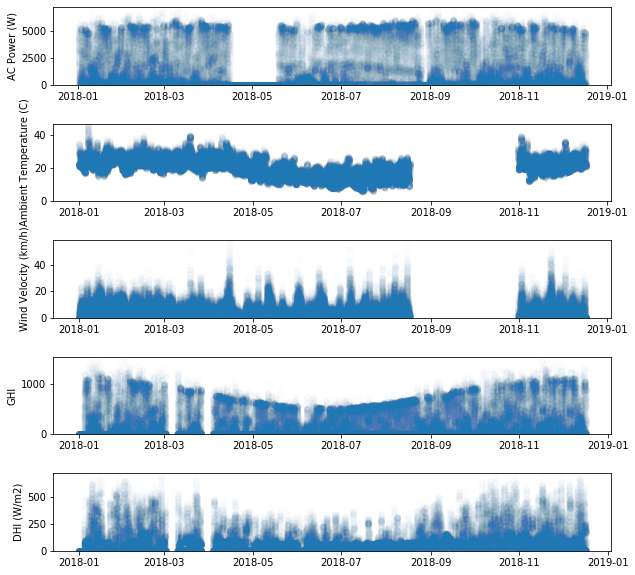

In [3]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

fig, ax = plt.subplots(5, figsize = (10,10))
plt.subplots_adjust(hspace = 0.5)
ax[0].plot(df1.index, df1['A.Ms.Watt'], 'o', alpha = 0.01)
ax[0].set_ylim(0, df1['A.Ms.Watt'].max())
ax[0].set_ylabel('AC Power (W)');
ax[1].plot(df1.index, df1['TmpAmb C'], 'o', alpha = 0.01)
ax[1].set_ylim(0, df1['TmpAmb C'].max())
ax[1].set_ylabel('Ambient Temperature (C)');
ax[2].plot(df1.index, df1['WindVel km/h'], 'o', alpha = 0.01)
ax[2].set_ylim(0, df1['WindVel km/h'].max())
ax[2].set_ylabel('Wind Velocity (km/h)');
ax[3].plot(df1.index, df1['GHI'], 'o', alpha = 0.01)
ax[3].set_ylim(0, df1['GHI'].max())
ax[3].set_ylabel('GHI');
ax[4].plot(df1.index, df1['DHI'], 'o', alpha = 0.01)
ax[4].set_ylim(0, df1['DHI'].max())
ax[4].set_ylabel('DHI (W/m2)');

## 2.4.4 Using the Data: Linear Regression
Now that we've got some data, we can try our best at some simple linear regression. Only having 1 year of data loaded means that calculating the performance loss is vulnerable to noise. We can see from the result below that we get a positive gradient on our slope, which means that we have negative performance loss; this is likely due to the seasonality of the data and is one of the key reasons we have alternative methodologies for calculating performance loss. It is good to know, however, that linear regression does at least work on our dataframe as it is, which allows us to move on. When we return with a full suite of data years this result will be less affected by seasonality noise as will be more clear.

slope: 0.000040    intercept: 167.211366
R-squared: 0.001355


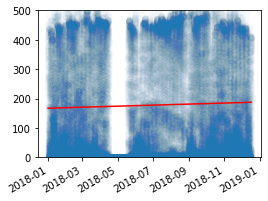

In [4]:
from scipy import stats
freq = pd.infer_freq(df1.index[:10])

# Set the frequency of the dataframe
df1 = df1.resample(freq).median()
# Calculate energy yield in Wh
df1['energy'] = df1['A.Ms.Watt'] * pd.to_timedelta(df1['A.Ms.Watt'].index.freq).total_seconds()/(3600.0)

y = df1['energy'].to_numpy()
x = (df1.index - df1.index[0])/np.timedelta64(1, 'm')

mask = ~np.isnan(x) & ~np.isnan(y) # Mask the NaN's so we don't include them
slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask], y[mask])

print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f" % r_value**2)

fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(df1.index, df1.energy, 'o', label='original data', alpha = 0.01)
ax.plot(df1.index, intercept + slope*x, 'r', label='fitted line')
ax.set_ylim(0,500)
fig.autofmt_xdate()

## 2.4.5 Using the data: STL
After getting a combined Array-Weather dataframe, I then attempted to use it for any of the processing methodologies available. I opted to try STL as RDTools-YOY requires more than one year of data (we only have 2018 imported) and weather for all years (only weather data for 2017-18 available as current on unsw servers). Doubtful that STL would simply work straight up we try to execute it, but naturally it throws us an error. This is where we are working next now that the data is in a useable form.

In [5]:
import seaborn as sns
freq = pd.infer_freq(df1.index[:10])
df1 = df1.resample(freq).median()

try:
    from statsmodels.tsa.seasonal import STL
    stl = STL(df1['A.Ms.Watt'], seasonal=13)
    res = stl.fit()
    fig = res.plot()
    print("done")
except AssertionError as error:
    print(error)
    print("STL calculation failed")

ValueError: freq T not understood. Please report if you think this is in error.